# Tasks for today's lecture:
* Continue working with the databases
* Identify the subsample of data -- SP500 components in terms of permno/ cusip
* Get the SP500 components in terms of SECID (OptionMetrics identifier)
* Define and download option-based characteristics from OptionMetrics 
* Think about matching the sample with CRSP-based returns 
* Discuss methods to study cross-sectional predictability by asset characteristics 
* Using option-based characteristics, implement portfolio sorts and Fama-MacBeth regressions
* Discuss time-series predictability of returns



**Some useful info:** 
* Linearmodels: https://bashtage.github.io/linearmodels/index.html 
* Statmodels: https://www.statsmodels.org/stable/index.html
* Scipy/ scikit-learn: https://www.scipy.org/index.html + https://scikit-learn.org/stable/ 

In [132]:
# after we install all the packages, import all of them for the use in today's lecture!
# database access
import pandas_datareader as web
import quandl as quandl
import wrds as wrds
# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
# stats 
import statsmodels.api as sm
from scipy import stats
from scipy.stats.mstats import winsorize

# some useful path and file names
path         = Path('../../zData')

# some file names 
fn_pred          = path / 'PredictorData2019.xlsx'
fn_h5_stocks     = path / 'stocks.h5'
fn_csv_factors   = path / 'ff_fact.csv'
fn_excel_factors = path / 'ff_fact.xls'
fn_h5_factors    = path / 'ff_predictors.h5'

fn_link          = path / 'permno_cusip_link.h5'
fn_optd          = path / 'om_daily.h5'
fn_optm          = path / 'om_monthly.h5'

fn_sp500comp     = path / 'SP500_Index_Constitutes2019.csv'
fn_quandl_key = path / 'quandl-key.xlsx'

# adding for this class
fn_link_all = path / 'daily_permno_secid_cusip_link.csv.zip'

# Check the data we have already prepared
* Data for stocks: returns, market cap, etc. 
* Linking tables: CRSP/Compustat/OptionMetrics, etc. 

In [4]:
## e.g. for stocks we can do the following
## to see what we have in the file we can run
with pd.HDFStore(fn_h5_stocks) as store:
    print(store.keys())

['/stoxx/panel', '/stoxx/permno_cusip_link']


Reading the linking file turned out to be bit more complex! I did not realize 
that by zipping on my Mac two files got zipped! So when you try to read the file
as usual -- it does not work -- try it out :) 


In [94]:
# pd.read_csv(fn_link_all)
# -> ValueError: Multiple files found in compressed zip file 
# ['daily_permno_secid_cusip_link.csv', '__MACOSX/._daily_permno_secid_cusip_link.csv']

In [133]:
# googling for couple of minutes gives a solution... usea special library: zipfile 
from zipfile import ZipFile
zip_file = ZipFile(fn_link_all)

link_all = pd.read_csv(zip_file.open('daily_permno_secid_cusip_link.csv'))

In [96]:
link_all

,permno,date,cusip,secid,ticker,issuer
0,10057.0,1995-01-03,00462610,5008.0,NaN,NaN
1,10057.0,1995-01-04,00462610,5008.0,NaN,NaN
2,10057.0,1995-01-05,00462610,5008.0,NaN,NaN
3,10057.0,1995-01-06,00462610,5008.0,NaN,NaN
4,10057.0,1995-01-09,00462610,5008.0,NaN,NaN
...,...,...,...,...,...,...
4908503,93429.0,2019-12-24,12503M10,143077.0,CBOE,CBOE GLOBAL MARKETS INC.
4908504,93429.0,2019-12-26,12503M10,143077.0,CBOE,CBOE GLOBAL MARKETS INC.
4908505,93429.0,2019-12-27,12503M10,143077.0,CBOE,CBOE GLOBAL MARKETS INC.
4908506,93429.0,2019-12-30,12503M10,143077.0,CBOE,CBOE GLOBAL MARKETS INC.


In [152]:
# using this link we can add secid to the CRSP file or permno to OM file 

datain = pd.read_hdf(fn_h5_stocks, key = '/stoxx/panel')

# # # merge like here -- what do we get? 
# dataall = pd.merge(datain, link_all.loc[:,['permno', 'date', 'secid']], on = ['permno','date'])

# # check
# link_all.dtypes

# # convert 
link_all.loc[:,'date'] = pd.to_datetime(link_all.loc[:,'date'])
# # NOW
dataall = pd.merge(datain, link_all.loc[:,['permno', 'date', 'secid']], on = ['permno','date'])

# think: how ='inner' now (by default), is that a good idea? 

In [135]:
dataall

,permno,date,cusip,ret,prc,shrout,sp500,mktcap,secid
0,10078.0,2000-01-03,86681020,-0.012107,76.500000,1561106.0,NaN,119.424609,110611.0
1,10078.0,2000-01-04,86681020,-0.062092,71.750000,1561106.0,0.009915,112.009355,110611.0
2,10078.0,2000-01-05,86681020,0.001742,71.875000,1561106.0,0.009672,112.204494,110611.0
3,10078.0,2000-01-06,86681020,-0.053913,68.000000,1561106.0,0.009689,106.155208,110611.0
4,10078.0,2000-01-07,86681020,0.056985,71.875000,1561106.0,0.009185,112.204494,110611.0
...,...,...,...,...,...,...,...,...,...
3660665,93429.0,2019-12-24,12503M10,0.005664,118.970001,110861.0,0.000472,13.189133,143077.0
3660666,93429.0,2019-12-26,12503M10,0.000672,119.050003,110861.0,0.000475,13.198002,143077.0
3660667,93429.0,2019-12-27,12503M10,-0.001764,118.839996,110861.0,0.000473,13.174721,143077.0
3660668,93429.0,2019-12-30,12503M10,0.003450,119.250000,110861.0,0.000472,13.220174,143077.0


# A quick chat about return predictability 
* Time-series predictability
* Cross-sectional predictability 
* Uses of both and testing both 

In [136]:
# libraries we might use for testing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import linearmodels as lm
from linearmodels.panel import compare  

# WRDS: OptionMetrics

In [137]:
db = wrds.Connection(wrds_username='gvfs')
# db.create_pgpass_file()

Loading library list...
Done


In [138]:
params = {}
dataall.secid
params['secids'] = tuple(dataall.secid.unique())


In [139]:
len(params['secids'])

1004

In [109]:
# sql = '''
# select date, secid, AVG(impl_volatility) as iv 
# from optionm.vsurfd%(year)s
# where secid in %(secids)s and days = 30 and abs(delta)<=50
# group by date, secid
# '''

# params['year']   = 2000
# params['secids'] = tuple(dataall.secid.unique())
# data = db.raw_sql(sql,params = params)

# data.loc[:,'date'] = pd.to_datetime(data.loc[:,'date'])



In [153]:
# print(data.head())
# data.describe()

In [154]:
# by observing some weird characteristic values you might want to winsorize them 
# from scipy.stats.mstats import winsorize

# vars2wins = ['iv'] 

# for z in vars2wins:
#     goods    = data[z].notna()
#     data.loc[goods,z] = winsorize(data.loc[goods,z], limits=0.01).data
# data.describe()

In [140]:
sql = '''
select a.date, a.secid, a.iv-b.iv as skew, c.iv from 

(select date, secid, impl_volatility as iv 
from optionm.vsurfd%(year)s
where secid in %(secids)s and days = 30 and delta=50) as a, 

(select date, secid, impl_volatility as iv 
from optionm.vsurfd%(year)s
where secid in %(secids)s and days = 30 and delta=-10) as b, 

(select date, secid, AVG(impl_volatility) as iv 
from optionm.vsurfd%(year)s
where secid in %(secids)s and days = 30 and abs(delta)<=50
group by date, secid) as c

where a.date= b.date and a.secid = b.secid 
and a.date = c.date and a.secid = c.secid
'''

params['year'] = 2000
data           = db.raw_sql(sql,params = params)

for y in range(2001,2020):
    print('Processing year ', y)
    params['year'] = y
    data = pd.concat([data, db.raw_sql(sql,params = params)])
    
data.loc[:,'date'] = pd.to_datetime(data.loc[:,'date'])

Processing year  2001
Processing year  2002
Processing year  2003
Processing year  2004
Processing year  2005
Processing year  2006
Processing year  2007
Processing year  2008
Processing year  2009
Processing year  2010
Processing year  2011
Processing year  2012
Processing year  2013
Processing year  2014
Processing year  2015
Processing year  2016
Processing year  2017
Processing year  2018
Processing year  2019


In [155]:
data.to_hdf(fn_optd, key = 'om_daily', mode= 'a',data_columns = True, complib = 'zlib')

# How to proceed next? 
* Check the predictability in the cross-section
* Build the predictor using selected characteristics 
* Create optimal portfolios --- 

Depending on the library we use, some data orgaization can be more convenient then the other..

In any case, question: what are we predicting? 

In [156]:
data = pd.read_hdf(fn_optd, key = 'om_daily')
data.dtypes
# dataall

date     datetime64[ns]
secid           float64
skew            float64
iv              float64
dtype: object

In [157]:
# create future returns
# let us take the data we got from CRSP and merge it with OM data -- taking IV
dataall = pd.merge(dataall, data, how = 'inner', on = ['secid','date'])

# WE USE INNER MERGER HERE -- BA CAREFUL FOR YOUR OWN WORK LATER ON

In [158]:
dataall

,permno,date,cusip,ret,prc,shrout,sp500,mktcap,secid,skew,iv
0,10078.0,2000-01-03,86681020,-0.012107,76.500000,1561106.0,NaN,119.424609,110611.0,-0.107443,0.655765
1,10078.0,2000-01-04,86681020,-0.062092,71.750000,1561106.0,0.009915,112.009355,110611.0,-0.075999,0.666087
2,10078.0,2000-01-05,86681020,0.001742,71.875000,1561106.0,0.009672,112.204494,110611.0,-0.070203,0.678037
3,10078.0,2000-01-06,86681020,-0.053913,68.000000,1561106.0,0.009689,106.155208,110611.0,-0.047229,0.690546
4,10078.0,2000-01-07,86681020,0.056985,71.875000,1561106.0,0.009185,112.204494,110611.0,-0.053474,0.676763
...,...,...,...,...,...,...,...,...,...,...,...
3482414,93429.0,2019-12-24,12503M10,0.005664,118.970001,110861.0,0.000472,13.189133,143077.0,-0.114522,0.201264
3482415,93429.0,2019-12-26,12503M10,0.000672,119.050003,110861.0,0.000475,13.198002,143077.0,-0.116238,0.205552
3482416,93429.0,2019-12-27,12503M10,-0.001764,118.839996,110861.0,0.000473,13.174721,143077.0,-0.088774,0.205807
3482417,93429.0,2019-12-30,12503M10,0.003450,119.250000,110861.0,0.000472,13.220174,143077.0,-0.156374,0.218705


In [160]:
dataall.columns

Index(['permno', 'date', 'cusip', 'ret', 'prc', 'shrout', 'sp500', 'mktcap',
       'secid', 'skew', 'iv'],
      dtype='object')

In [166]:
vars2wins = ['ret','iv','skew'] 

for z in vars2wins:
    goods    = dataall[z].notna()
    dataall.loc[goods,z] = winsorize(dataall.loc[goods,z], limits=0.01).data

dataall.loc[:,['ret', 'skew', 'iv']].describe()

,ret,skew,iv
count,3.482083e+06,3.471300e+06,3.471300e+06
mean,5.345547e-04,-1.122852e-01,3.689969e-01
std,2.185462e-02,9.367475e-02,1.777679e-01
min,-7.060523e-02,-5.131810e-01,1.469888e-01
25%,-9.722180e-03,-1.424240e-01,2.469117e-01
50%,3.967527e-04,-8.748000e-02,3.217351e-01
75%,1.063002e-02,-5.499300e-02,4.360732e-01
max,7.562267e-02,4.492000e-02,1.076310e+00


In [167]:
# run a simple Fama-MacBeth regression for test the predcitability --
# DONT FORGET TO CREATE RETURNS THAT YOU PREDICT!

# NOTE: there was a typo in 5-day return formula -- adjusted now!

dataall.sort_values(by = ['permno','date'], inplace = True)

dataall.loc[:,'fret1w'] = dataall.groupby(['permno'])['ret'].\
                            apply(lambda z: z.rolling(window = 5).\
                                apply(lambda x: np.exp(np.sum(np.log(1+x)))-1 )).shift(-5)
dataall.loc[:,'fret1d'] = dataall.groupby(['permno'])['ret'].shift(-1)

In [168]:
dataall

,permno,date,cusip,ret,prc,shrout,sp500,mktcap,secid,skew,iv,fret1w,fret1d
0,10078.0,2000-01-03,86681020,-0.012107,76.500000,1561106.0,NaN,119.424609,110611.0,-0.107443,0.655765,0.010593,-0.062092
1,10078.0,2000-01-04,86681020,-0.062092,71.750000,1561106.0,0.009915,112.009355,110611.0,-0.075999,0.666087,0.064659,0.001742
2,10078.0,2000-01-05,86681020,0.001742,71.875000,1561106.0,0.009672,112.204494,110611.0,-0.070203,0.678037,0.016673,-0.053913
3,10078.0,2000-01-06,86681020,-0.053913,68.000000,1561106.0,0.009689,106.155208,110611.0,-0.047229,0.690546,0.116148,0.056985
4,10078.0,2000-01-07,86681020,0.056985,71.875000,1561106.0,0.009185,112.204494,110611.0,-0.053474,0.676763,0.098690,0.075623
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482414,93429.0,2019-12-24,12503M10,0.005664,118.970001,110861.0,0.000472,13.189133,143077.0,-0.114522,0.201264,NaN,0.000672
3482415,93429.0,2019-12-26,12503M10,0.000672,119.050003,110861.0,0.000475,13.198002,143077.0,-0.116238,0.205552,NaN,-0.001764
3482416,93429.0,2019-12-27,12503M10,-0.001764,118.839996,110861.0,0.000473,13.174721,143077.0,-0.088774,0.205807,NaN,0.003450
3482417,93429.0,2019-12-30,12503M10,0.003450,119.250000,110861.0,0.000472,13.220174,143077.0,-0.156374,0.218705,NaN,0.006289


In [169]:
dataFM = dataall.set_index(['permno','date']).copy()
dataFM['constant'] = 1.0

endog = ['fret1w']
exog = ['constant','iv','skew']
modfit= lm.FamaMacBeth(dataFM[endog], dataFM[exog]).fit(cov_type='kernel')

modfit.summary

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):
/opt/anaconda3/lib/python3.8/site-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,fret1w,R-squared:,1.3e-05
Estimator:,FamaMacBeth,R-squared (Between):,-0.0230
No. Observations:,3467120,R-squared (Within):,0.0002
Date:,"Mon, Feb 08 2021",R-squared (Overall):,1.3e-05
Time:,16:28:11,Log-likelihood,5.642e+06
Cov. Estimator:,Fama-MacBeth Kernel Cov,,
,,F-statistic:,22.541
Entities:,1000,P-value,0.0000
Avg Obs:,3467.1,Distribution:,"F(2,3467117)"
Min Obs:,1.0000,,
Max Obs:,5027.0,F-statistic (robust):,8.9276


<AxesSubplot:xlabel='date'>

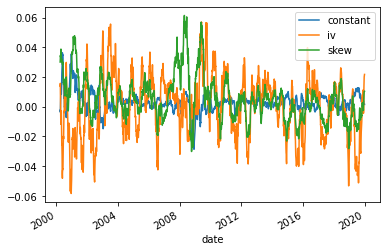

In [172]:
modfit.all_params.rolling(window=63).mean().plot()

In [19]:
# data.set_index(['date','secid'], inplace = True)
# data = data.groupby(level = [0,1]).first()
# flds2save = ['ret','iv','skew']

# # reindex all frames to the same permno structure 
# cols  = data.index.get_level_values(1).unique()
# opt   = {z:data.loc[:,z].unstack().reindex(columns = cols) for z in flds2save}
# opt['vrp'] = opt['iv']**2 - opt['ret'].rolling(30).var()*252

# for z in opt.keys():
#     zz = opt[z]
#     zz.to_hdf(fn_optd, key = 'om/'+z, mode= 'a', data_columns = True, complib = 'zlib')
#     print('..saved ', z)

In [7]:
# read the daily data back if needed
# opt = {}
# vars  = ['ret','iv','skew','vrp']
# for z in vars: 
#     opt[z] = pd.read_hdf(fn_optd,'om/'+z)

In [9]:
# dict for monthly data - characteristics are shifted by 1 so that 
# past chartacteristic matches the current month return
# optm   = {}

# lret   = np.log(opt['ret']+1)
# retm   = np.exp(lret.resample('BM').sum())-1 
# optm['ret'] = retm

# vars  = ['iv','skew','vrp']
# for z in vars:
#     optm[z] = opt[z].resample('BM').last().shift(1)
    
# for z in optm.keys():
#     zz = optm[z]
#     zz.to_hdf(fn_optm, key = 'om/'+z, mode= 'a', data_columns = True, complib = 'zlib')
#     print('..saved ', z)        

Here is another way of running FM regressions using unstacked data/ "semi-automatic" procedure

Run simple Fama-MacBeth analysis to check the predictive abilities of the selected chatacteristics. Note that you can easily modify the procedure to accomodate shrinkage -- LASSO, RIDGE, etc. 

In [10]:
# coeff = pd.DataFrame(index = retm.index, columns = vars)

# for t in coeff.index[2:]:
#     temp = pd.concat([optm[z].loc[t,:] for z in optm.keys()], axis = 1).dropna()
#     temp.columns = list(optm.keys())
    
#     Y     = temp.iloc[:,0]
#     X     = temp.iloc[:,1:]
#     X     = sm.add_constant(X).dropna()
#     model = sm.OLS(Y, X).fit()
#     coeff.loc[t,:] = model.params[vars]
# coeff = coeff.dropna()    

In [89]:
# coeff.plot()

In [90]:
# stats.ttest_1samp(coeff['vrp'], 0)

In [91]:
# print(coeff.mean())
# [stats.ttest_1samp(coeff[z], 0).statistic for z in coeff.columns]